# Part A > Time Series Regression

In [9]:
# Data Manipulation Dependencies
import numpy as np
import pandas as pd

# Graphing Dependencies
import matplotlib.pyplot as plt
import seaborn as sns

# Time Series Dependency
import statsmodels.tsa as time_series_analysis
from pmdarima.arima import arima

# 
from sklearn.cluster import KMeans

from typing import Union, List

In [10]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

## Import Data

In [11]:
df = pd.read_csv('./data/train.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date')

,Date,T,RH,Gas,Value
22,2004-01-04,-11.426042,19.742014,CO,1063.739583
678,2004-01-04,-11.426042,19.742014,NOx,745.482639
350,2004-01-04,-11.426042,19.742014,NMHC,859.059028
1006,2004-01-04,-11.426042,19.742014,O3,986.315972
52,2004-01-05,20.134375,52.178125,CO,1097.437500
...,...,...,...,...,...
307,2005-11-01,12.789583,64.092709,CO,1299.833333
1292,2005-12-01,11.962153,65.682986,O3,1455.788194
308,2005-12-01,11.962153,65.682986,CO,1301.940972
636,2005-12-01,11.962153,65.682986,NMHC,1135.673611


In [12]:
df.set_index(keys='Date', inplace=True)
df.head()

,T,RH,Gas,Value
Date,,,,
2004-10-03,12.020833,54.883334,CO,1316.500000
2004-11-03,9.833333,64.069791,CO,1244.062500
2004-12-03,11.292708,51.107292,CO,1281.562500
2004-03-13,12.866319,51.530903,CO,1330.555556
2004-03-14,16.016667,48.843750,CO,1360.927083


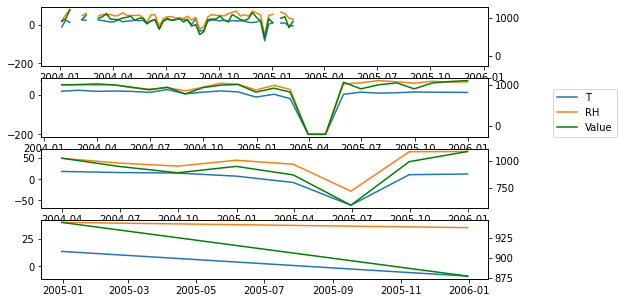

In [14]:
def get_data_grouped_by_date(df: pd.DataFrame, freq: Union[str, List[str]]):
    def get_plot(df: pd.DataFrame, fr: str, ax):
        df_tmp = df.copy()
        gbo = df_tmp.resample(rule=fr).mean()

        ax.plot(gbo.index, gbo['T'], label='T')
        ax.plot(gbo.index, gbo['RH'], label='RH')
        ax.plot([], [], color='g', label='Value')

        ax2 = ax.twinx()
        ax2.plot(gbo.index, gbo['Value'], color='green')
        return ax
    
    if type(freq) is str or len(freq) == 1:
        fig, ax = plt.subplots()
        get_plot(df, freq if type(freq) is str else freq[0], ax) #type: ignore
    else:
        fig, ax = plt.subplots(nrows=len(freq), figsize=(8, 5))
        for i, fr in enumerate(freq):
            get_plot(df, fr, ax[i])
        ax[-1].legend(bbox_to_anchor=(1.3, 3.3))

get_data_grouped_by_date(df=df, freq=['W', 'M', 'Q', 'Y'])

    Gas          T         RH        Value    Type
0    CO  11.634917  39.873729  1050.729347    Mean
1  NMHC  11.634917  39.873729   911.986217    Mean
2   NOx  11.634917  39.873729   812.609968    Mean
3    O3  11.634917  39.873729   975.768663    Mean
0    CO  18.832292  46.078993  1080.177083  Median
1  NMHC  18.832292  46.078993   942.102431  Median
2   NOx  18.832292  46.078993   824.156250  Median
3    O3  18.832292  46.078993   993.616319  Median


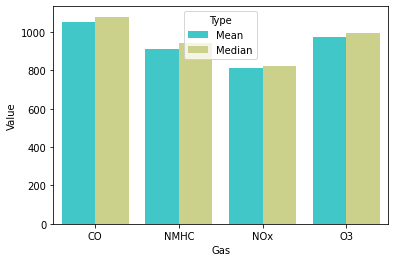

In [15]:
def plot_(df):
    # fig, ax = plt.subplots(nrows=2, ncols=2)
    gb = df.groupby(by='Gas', as_index=False)
    mean_ = gb.mean()
    mean_['Type'] = ['Mean'] * mean_.shape[0]
    types = ['Mean', 'Median']
    comb_df = pd.DataFrame()
    for i, frame in enumerate([gb.mean(), gb.median()]):
        tmp_df = frame
        tmp_df['Type'] = types[i]
        comb_df = pd.concat(objs=(comb_df, tmp_df), axis=0)
    # print(pd.merge(left=gb.mean(), right=gb.median(), on='Gas'))
    print(comb_df)
    sns.barplot(data=comb_df, x='Gas', y='Value', hue='Type', palette='rainbow')
plot_(df)

In [16]:
def get_stationarity_of_columns(df: pd.DataFrame, significance_level: float = 0.01):
    df_tmp = df.copy()
    for col in df.columns:
        if df[col].dtype.kind in 'biufc':
            p_value = round(adfuller(df_tmp.resample(rule='M').mean()[col])[1], 5)
            if p_value < significance_level:
                print(f'{col}:\tStationary ({p_value})'.expandtabs(tabsize=10))
            else:
                print(f'{col}:\tNon-Stationary ({p_value})'.expandtabs(tabsize=10))
            # seasonal_decompose(df_tmp.resample(rule='M')[col].mean()).plot()

get_stationarity_of_columns(df)

T:        Non-Stationary (0.02303)
RH:       Non-Stationary (0.99676)
Value:    Non-Stationary (0.06322)


C:\Users\ethanol\AppData\Local\Temp/ipykernel_26572/1423303598.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_pacf(gbo['Value'], lags=5).show()


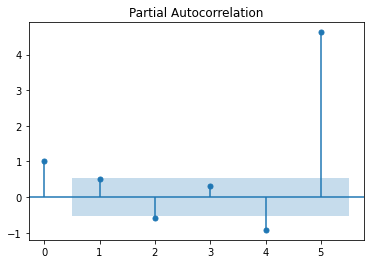

In [60]:
from statsmodels.graphics.tsaplots import plot_pacf

def stuff(df):
    df_tmp = df.copy()
    gbo = df_tmp.resample('2M').mean()
    plot_pacf(gbo['Value'], lags=5).show()

stuff(df)

C:\Users\ethanol\AppData\Local\Temp/ipykernel_26572/3606084815.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_acf(gbo['Value'], lags=5).show()


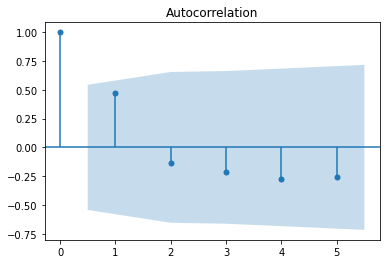

In [61]:
from statsmodels.graphics.tsaplots import plot_acf

def stuff2(df):
    df_tmp = df.copy()
    gbo = df_tmp.resample('2M').mean()
    plot_acf(gbo['Value'], lags=5).show()

stuff2(df)

In [42]:
def arima(df: pd.DataFrame, freq: str):
    df_tmp = df.copy()
    df_grouped = df_tmp.resample(freq).mean()
    model = time_series_analysis.arima.model.ARIMA(df_grouped['Value'], order=(5, 1, 0))
    res = model.fit()
    print(res.summary())

arima(df=df, freq='2M')

                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                   13
Model:                 ARIMA(0, 1, 2)   Log Likelihood                 -79.251
Date:                Tue, 27 Jul 2021   AIC                            164.502
Time:                        20:58:45   BIC                            165.957
Sample:                    01-31-2004   HQIC                           163.963
                         - 01-31-2006                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0008    130.794    5.8e-06      1.000    -256.351     256.352
ma.L2         -0.9992      0.501     -1.995      0.046      -1.981      -0.017
sigma2      2.343e+04      0.006   4.21e+06      0.0

c:\Users\ethanol\Documents\SP\Current\AI and Machine Learning (AIML)\CA2\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [30]:
from pmdarima.arima import auto_arima

def auto(df: pd.DataFrame, freq: str):
    df_tmp = df.copy()
    gbo = df_tmp.resample(rule=freq).mean()
    arima_model = auto_arima(gbo['Value'], seasonal=True, m=2)
    print(arima_model.summary())

auto(df, '2M')

                                SARIMAX Results                                
Dep. Variable:                       y   No. Observations:                   13
Model:             SARIMAX(0, 1, 0, 2)   Log Likelihood                 -80.439
Date:                 Tue, 27 Jul 2021   AIC                            162.877
Time:                         20:57:11   BIC                            163.275
Sample:                              0   HQIC                           162.627
                                  - 13                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.311e+05    5.9e+04      2.221      0.026    1.54e+04    2.47e+05
Ljung-Box (L1) (Q):                   1.37   Jarque-Bera (JB):                 0.03
Prob(Q):                              0

# Part B > Clustering

## Import Exclusive Dependencies

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

## Import Data

In [ ]:
df2 = pd.read_csv('./data/Mall_Customers.csv', index_col=0)
df2.rename(mapper={'Genre': 'Gender'}, axis=1, inplace=True)
df2.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
CustomerID,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40


In [ ]:
['Eigenvalue', 'Explained Variance', 'Cumulative Explained Variance'].extend(df2.drop(columns='Gender').columns.tolist())

In [ ]:
from typing import Union, List

def get_pca_results(df: pd.DataFrame, ignore_cols: Union[str, List[str]]):
    df_scaled = StandardScaler().fit_transform(X=df.drop(columns=ignore_cols))

    pca = PCA(n_components=df_scaled.shape[1]).fit(X=df_scaled)
    header = ['Eigenvalue', 'Explained Variance', 'Cumulative Explained Variance']
    header.extend(df.drop(columns=ignore_cols).columns.tolist())
    eigenvalues = pca.explained_variance_
    eigenvectors = pca.components_
    expl_var = pca.explained_variance_ratio_
    cum_expl_var = pca.explained_variance_ratio_.cumsum()
    pca_results = pd.DataFrame(
        data=np.hstack((
            eigenvalues.reshape(-1, 1),
            expl_var.reshape(-1, 1),
            cum_expl_var.reshape(-1, 1),
            eigenvectors
        )),
        columns=header,
        index=[f'PC {i + 1}' for i in range(df_scaled.shape[1])]
    )

    df_transformed = pd.DataFrame(
        data=pca.transform(df_scaled),
        index=df.index,
        columns=[f'PC {i + 1}' for i in range(df_scaled.shape[1])]
    )

    return pca_results, df_transformed

pca_results, df2_transformed = get_pca_results(df=df2, ignore_cols='Gender')
pca_results

,Eigenvalue,Explained Variance,Cumulative Explained Variance,Age,Annual Income (k$),Spending Score (1-100)
PC 1,1.334658,0.442662,0.442662,0.706382,-0.048024,-0.706199
PC 2,1.004273,0.333084,0.775745,0.030141,0.998832,-0.037775
PC 3,0.676144,0.224255,1.000000,-0.707188,-0.005398,-0.707005


<AxesSubplot:title={'center':'Scree Plot for PCA (df2)'}, ylabel='Eigenvalue'>

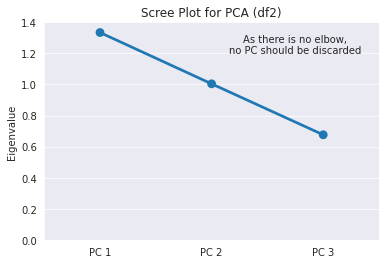

In [ ]:
def scree_plot(df: pd.DataFrame, pca: pd.DataFrame):
    with sns.axes_style(style='darkgrid'):
        ax = sns.pointplot(data=pca, x=pca.index, y=pca['Eigenvalue'])
        ax.set(
            title='Scree Plot for PCA (df2)',
            ylim=(0, 1.4)
        )
        ax.annotate(text='As there is no elbow,\nno PC should be discarded', xy=(1.75, 1.2), ha='center')
        return ax

scree_plot(df2, pca_results)

In [ ]:
def get_dist_score(df: pd.DataFrame, clusters: int):
    model = KMeans(n_clusters=clusters).fit(X=df[['Annual Income (k$)', 'Spending Score (1-100)']])
    centers = model.cluster_centers_
    y_hat = model.predict(df[['Annual Income (k$)', 'Spending Score (1-100)']])
    # plt.scatter(centers[:,0], centers[:,1])
    # sns.scatterplot(x=df['Annual Income (k$)'], y=df['Spending Score (1-100)'], hue=y_hat)
    df_tmp = pd.concat(objs=(df, pd.Series(data=y_hat, name='Class', index=df.index)), axis=1)
    means = []
    stds = []
    count = []
    for i, c in enumerate(centers):
        # plt.annotate(text=str(model.predict(c.reshape(-1, 2))), xy=(c[0], c[1])) # type: ignore
        class_i = df_tmp[df_tmp['Class'] == i][['Annual Income (k$)', 'Spending Score (1-100)']]
        distances = np.linalg.norm(class_i - centers[i, :], axis=1)
        # print(i, int(class_i.count(axis=0).mean()), distances.mean(), distances.std())
        # count.append(int(class_i.count(axis=0).mean()))
        means.append(distances.mean())
        # stds.append(distances.std())
    return np.std(means)

get_dist_score(df2, 5)

2.508316588079013

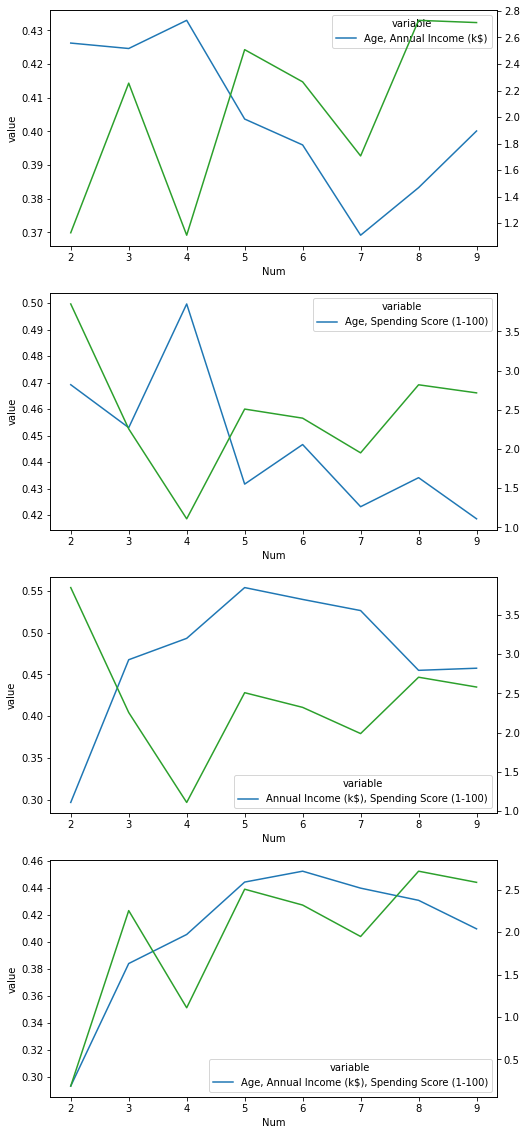

In [ ]:
# type: ignore
from sklearn.metrics import silhouette_score
from more_itertools import powerset

def get_silhouette_score_plot(df: pd.DataFrame, ignore_cols: Union[str, List[str]] = None):
    ignore_cols = ignore_cols if ignore_cols is not None else [] 
    col_combs = list(filter(lambda x: len(x) > 1, list(powerset(df.drop(columns=ignore_cols).columns))))
    # n = len(cols)
    # n = 10
    # fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10, 8))
    # c = 0
    fig, ax = plt.subplots(nrows=len(col_combs), figsize=(8, len(col_combs) * 5))
    for jj, col_comb in enumerate(col_combs):
        current_axis = ax[jj] if len(col_combs) > 1 else ax
        clusters = list(range(2, 10))
        sil = pd.DataFrame(data=clusters, columns=['Num'])
        dists = []
        silhoutte_scores = []
        col_list = [*col_comb]
        for i in clusters:
            model = KMeans(n_clusters=i).fit(X=df[col_list])
            y_hat = model.predict(X=df[col_list])
            dists.append(get_dist_score(df, i))
            silhoutte_scores.append(silhouette_score(X=df[col_list], labels=y_hat))
        col_str = ', '.join(col_list)
        sil = pd.concat(objs=(sil, pd.Series(
            name=col_str,
            data=silhoutte_scores
        )), axis=1)
        # print(sil.melt(id_vars='Num'))
        sns.lineplot(data=sil.melt(id_vars='Num'), x='Num', y='value', hue='variable', ax=current_axis)
        # print(np.array(dists)[:,0])
        # sns.lineplot(x=clusters, y=np.array(dists)[:, 0], ax=current_axis.twinx(), color='tab:orange')
        sns.lineplot(x=clusters, y=dists, ax=current_axis.twinx(), color='tab:green')
        # sns.lineplot(x=clusters, y=np.array(dists)[:, 2], ax=current_axis.twinx(), color='tab:grey')
        # ax.legend(bbox_to_anchor=(2, 1))

get_silhouette_score_plot(df=df2, ignore_cols='Gender')

Silhouette Score (4): 0.4931963109249047
Silhouette Score (5): 0.553931997444648


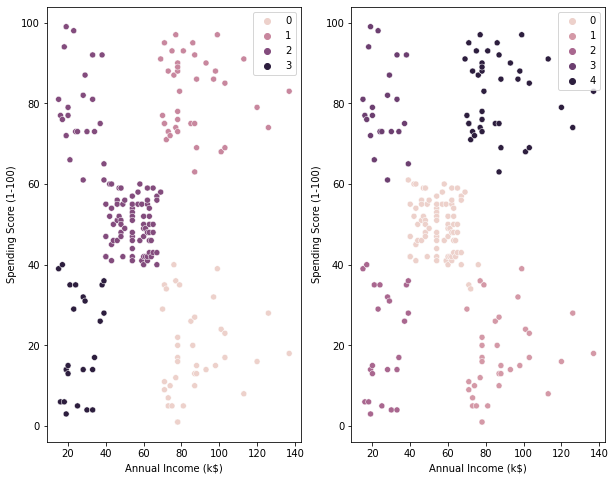

In [ ]:
cluster_params = [4, 5]
fig, ax = plt.subplots(ncols=2, figsize=(10, 8))
for i, cl in enumerate(cluster_params):
    model = KMeans(n_clusters=cl).fit(X=df2[['Annual Income (k$)', 'Spending Score (1-100)']])
    y_hat = model.predict(df2[['Annual Income (k$)', 'Spending Score (1-100)']])
    sns.scatterplot(data=df2, x='Annual Income (k$)', y='Spending Score (1-100)', hue=y_hat, ax=ax[i])
    print(f'Silhouette Score ({cl}):', silhouette_score(X=df2[['Annual Income (k$)', 'Spending Score (1-100)']], labels=model.labels_, metric='euclidean'))

In [ ]:
import plotly.express as px
from sklearn.cluster import DBSCAN, OPTICS, AgglomerativeClustering, AffinityPropagation

for mo in [KMeans(n_clusters=6), DBSCAN(eps=15, min_samples=15), OPTICS(max_eps=18)]:
    colrs = mo.fit_predict(X=df2[['Annual Income (k$)', 'Age', 'Spending Score (1-100)']])
    fig = px.scatter_3d(data_frame=df2, x='Annual Income (k$)', y='Age', z='Spending Score (1-100)', color=colrs, title=type(mo).__name__ + ' ' + str(round(silhouette_score(X=df2[['Annual Income (k$)', 'Age', 'Spending Score (1-100)']], labels=colrs), 2)), color_continuous_scale=px.colors.sequential.Rainbow)
    fig.show()

ModuleNotFoundError: No module named 'plotly'